In [23]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_2d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [5]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [7]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape
input_layer = tf.keras.layers.Input(shape=(inputShape))
numClasses = len(bbdc.LABEL_DICT)

24009it [01:54, 210.07it/s]
3047it [00:13, 221.71it/s]
2988it [00:13, 223.15it/s]


In [21]:
inputShape = X_train[0].shape
input_layer = tf.keras.layers.Input(shape=(inputShape))
numClasses = len(bbdc.LABEL_DICT)

In [29]:
channels = [4, 8, 16, 32]
#modelsForSingleClasses = [unet.u_net(None, channels, lessParameter = True, numClasses=2) for i in range(numClasses)]
modelsForSingleClasses = [unet.u_net_2d(None, channels, numClasses=2, inputLayer = input_layer) for i in range(numClasses)]

In [26]:
Y_train_classes = [np.expand_dims(Y_train[:,:,i], axis=-1) for i in range(numClasses)]
Y_train_classes = [np.append(y, 1-y, axis=-1) for y in Y_train_classes]

Y_validation_classes = [np.expand_dims(Y_validation[:,:,i], axis=-1) for i in range(numClasses)]
Y_validation_classes = [np.append(y, 1-y, axis=-1) for y in Y_validation_classes]

Y_test_classes = [np.expand_dims(Y_test[:,:,i], axis=-1) for i in range(numClasses)]
Y_test_classes = [np.append(y, 1-y, axis=-1) for y in Y_test_classes]

In [7]:
modelsForSingleClasses = [keras.models.load_model("ForestLastEpoch/model"+str(i)+".h5") for i in range(numClasses)]

In [30]:
histories = []
for classNumber in range(numClasses):
    print("Trainiere Modell für "+bbdc.invLabelMap[classNumber])
    checkpoint = keras.callbacks.ModelCheckpoint('model_'+str(classNumber)+'.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    opt = keras.optimizers.Adam(learning_rate=0.001)
    #modelsForSingleClasses[classNumber].compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
    modelsForSingleClasses[classNumber].compile(optimizer=opt, loss=bbdc.dice_loss, metrics=['mae', 'accuracy'])
    histories.append(modelsForSingleClasses[classNumber].fit(X_train,Y_train_classes[classNumber], batch_size=40, epochs=30, validation_data=(X_validation, Y_validation_classes[classNumber]), shuffle=True, callbacks=[checkpoint]))

Trainiere Modell für Noise
Epoch 1/30
200/200 [==============================] - 15s 69ms/step - loss: 0.0777 - mae: 0.1843 - accuracy: 0.8577 - val_loss: 0.0542 - val_mae: 0.1517 - val_accuracy: 0.9046

Epoch 00001: val_loss improved from inf to 0.05419, saving model to model_0.h5
Epoch 2/30
200/200 [==============================] - 13s 67ms/step - loss: 0.0386 - mae: 0.1002 - accuracy: 0.9312 - val_loss: 0.0387 - val_mae: 0.0975 - val_accuracy: 0.9310

Epoch 00002: val_loss improved from 0.05419 to 0.03874, saving model to model_0.h5
Epoch 3/30
200/200 [==============================] - 13s 66ms/step - loss: 0.0336 - mae: 0.0869 - accuracy: 0.9405 - val_loss: 0.0362 - val_mae: 0.0919 - val_accuracy: 0.9358

Epoch 00003: val_loss improved from 0.03874 to 0.03620, saving model to model_0.h5
Epoch 4/30
200/200 [==============================] - 13s 65ms/step - loss: 0.0306 - mae: 0.0798 - accuracy: 0.9458 - val_loss: 0.0337 - val_mae: 0.0781 - val_accuracy: 0.9401

Epoch 00004: val_los

In [32]:
for i in range(numClasses):
    modelsForSingleClasses[i].save("ForestLastEpoch_2d/model"+str(i)+".h5")

In [33]:
outputs = [classModel(input_layer) for classModel in modelsForSingleClasses]
outputs = [layers.Lambda(lambda x: x[:,:,:1])(o) for o in outputs]

x = layers.Concatenate(axis=2)(outputs)
x = layers.Conv1D(numClasses, kernel_size=3, padding='same')(x)
x = layers.Conv1D(numClasses, kernel_size=1, activation='softmax')(x)

majorityVoteModel = tf.keras.models.Model(inputs=input_layer, outputs=x)

In [35]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('majorityVoteModel.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
majorityVoteModel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = majorityVoteModel.fit(X_train,Y_train, batch_size=10, epochs=20, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/20
800/800 [==============================] - 265s 238ms/step - loss: 1.0844 - mae: 0.0716 - accuracy: 0.6873 - val_loss: 0.4643 - val_mae: 0.0334 - val_accuracy: 0.8722

Epoch 00001: val_loss improved from inf to 0.46430, saving model to majorityVoteModel.h5
Epoch 2/20
800/800 [==============================] - 187s 233ms/step - loss: 0.3771 - mae: 0.0285 - accuracy: 0.8936 - val_loss: 0.3527 - val_mae: 0.0240 - val_accuracy: 0.8971

Epoch 00002: val_loss improved from 0.46430 to 0.35270, saving model to majorityVoteModel.h5
Epoch 3/20
800/800 [==============================] - 187s 234ms/step - loss: 0.2686 - mae: 0.0202 - accuracy: 0.9219 - val_loss: 0.3169 - val_mae: 0.0220 - val_accuracy: 0.9056

Epoch 00003: val_loss improved from 0.35270 to 0.31690, saving model to majorityVoteModel.h5
Epoch 4/20
800/800 [==============================] - 188s 235ms/step - loss: 0.2194 - mae: 0.0165 - accuracy: 0.9347 - val_loss: 0.3217 - val_mae: 0.0216 - val_accuracy: 0.9004

Epoch 000

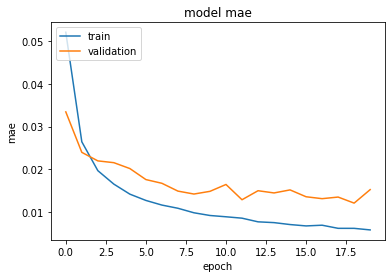

In [36]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

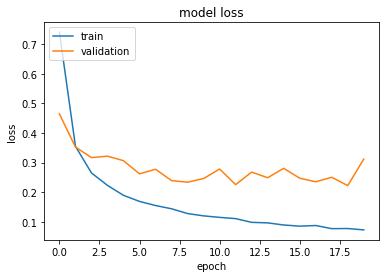

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

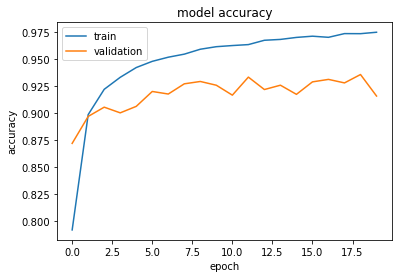

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
scores = majorityVoteModel.evaluate(X_test, Y_test)

32/32 [==============================] - 15s 272ms/step - loss: 0.3014 - mae: 0.0148 - accuracy: 0.9184


In [41]:
prediction = majorityVoteModel.predict(X_test)

In [50]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/forest_test.csv", index=False)
df.head()
evaluate.evaluate("../predictions/jannes/forest_test.csv", "./../data/test.csv")

(0.41597166441289757, 'Valid file')

In [48]:
postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/forest_pp_test.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/forest_pp_test.csv", "./../data/test.csv"))

(0.7845920817964224, 'Valid file')


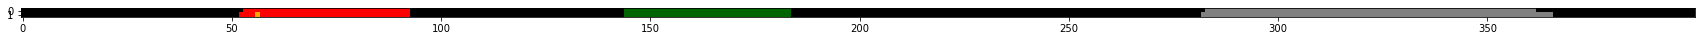

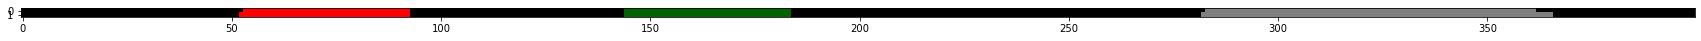

In [49]:
index = 14
bbdc.plotPredictionAndGT(Y_test, prediction, index) 
bbdc.plotPredictionAndGT(Y_test, postProcessedPrediction, index)

# Prediction der Challenge-Daten

In [51]:
X_challenge, _, timepoints, challengeFileList = bbdc.load_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
inputShape = X_challenge[0].shape

3000it [00:41, 71.97it/s]


In [53]:
challengePrediction = majorityVoteModel.predict(X_challenge)

In [64]:
postProcessedChalPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in challengePrediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedChalPrediction, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/majorityVoteUNet2d_challenge.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
from scipy.io.wavfile import read
fs = 16000

11233_mix.wav


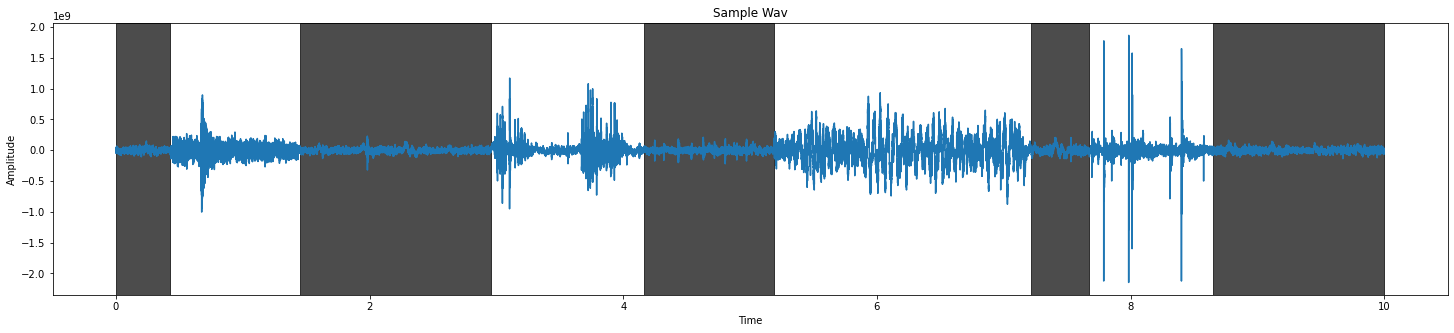

In [57]:
index = 1232
print(challengeFileList[index])
plt.figure(figsize=(25,5))
# read audio samples
input_data = read("../data/final_pre_dataset/eval/"+challengeFileList[index])
audio = input_data[1]
time=np.linspace(0, len(audio)/fs, num=len(audio))
plt.plot(time,audio)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Sample Wav")

groups = bbdc.groupSequences(challengePrediction[index], timepoints)
for group in groups:
    if group[0][0]==0:
        onset = group[0][1]
        offset = group[-1][1]
        plt.axvspan(onset, offset, alpha=0.7, color='black', ymin=0, ymax=1)

plt.show()